In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import cv2

from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, RandomFlip, RandomRotation
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tf_explain.core.grad_cam import GradCAM
from sklearn.metrics import precision_score, recall_score, f1_score
from lime import lime_image
from skimage.segmentation import mark_boundaries

## 1) The Dataset

- Assuming you have a classification problem, is it binary, multi-class or multi-label?
  - My dataset is more appropriate for binary classification problem, because it is supposed to make a difference between birds
    and flowers

- Show a few examples per class

- How many classes?
  - There are 2 classes - flowers and birds

- How many images per class?
  - flowers - 600
  - birds - 600

- Train/Test sizes
  - Train - 77% - 33% of the train data is used for validation test.
  - Test - 33%

- Image size?
  - The image size got reshaped from 256 by 256

- How are the images labeled?
  - Initially, the images were labeled by the verb, but since I am doing a binary classification - they were renamed to 0s and 1s

- Dataset source(s)?
  - Every image is taken from the Imsitu dataset.

## 2) Baselines

- Random guess accuracy?
  - Since the model solves binary classifications problems, the random guess would be 50%

- Human-Level Performance accuracy?
  - The score is not surprising at all - 100% - [excel](https://github.com/BredaUniversityADSAI/2022-23c-1fcmgt-reg-ai-01-MateyNedyalkov221889/blob/main/Human-Level%20Performance%20Accuracy(1-4).xlsx)

- Multilayer Perceptron accuracy?
  - The MLP accuracy is 75% as the only difference is that it was used another dataset - Imsitu

## 3) Preprocessing

Explain all the preprocessing steps you did.

In [2]:
X = []
y = []

# Iterate the folder with glob
for fpath in glob.glob('C:/Users/mened/OneDrive/Desktop/dataset/*.jpg'):
    # Opening images with OpenCV
    # Alternatives: PIL, Matplotlib
    im = cv2.imread(fpath, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # If the filename contains frying
    # label = 1
    # otherwise it must be microwaving so label = 0
    if 'birds' in fpath:
        label = 1
    else:
        label = 0
    
    im = cv2.resize(im, (256, 256))
    
    # Put image array to X
    # Put label to y
    X.append(im)
    y.append(label)
        

# Convert the list of arrays
# Into a numpy array
X = np.array(X)
y = np.array(y)

Label: 1


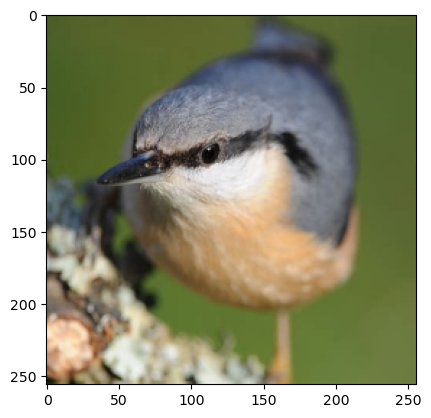

In [3]:
index = 1
plt.imshow(X[index])
print('Label:', y[index])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [5]:
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             zoom_range=0.2)

## 4) CNN architecture

In [6]:
base_model = VGG16(weights='imagenet', input_shape=(256, 256, 3), include_top=False)

base_model.trainable = False

In [7]:
model = Sequential()

model.add(Conv2D(30, kernel_size=3, strides=1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPool2D(2))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Conv2D(30, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.15))
model.add(BatchNormalization())
model.add(Conv2D(120, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPool2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 30)      840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 30)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 30)      0         
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 30)     120       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 30)      8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 30)       0

In [8]:
model_DA = Sequential()

model_DA.add(Conv2D(30, kernel_size=3, strides=1, activation='relu', input_shape=(256, 256, 3)))
model_DA.add(MaxPool2D(2))
model_DA.add(Dropout(0.1))
model_DA.add(BatchNormalization())
model_DA.add(Conv2D(30, kernel_size=3, strides=1, activation='relu'))
model_DA.add(MaxPool2D(2))
model_DA.add(Dropout(0.15))
model_DA.add(BatchNormalization())
model_DA.add(Conv2D(120, kernel_size=3, strides=1, activation='relu'))
model_DA.add(MaxPool2D(2))
model_DA.add(BatchNormalization())
model_DA.add(Dropout(0.2))
model_DA.add(Flatten())
model_DA.add(Dense(40, activation='relu'))
model_DA.add(BatchNormalization())
model_DA.add(Dropout(0.2))
model_DA.add(Dense(1, activation='sigmoid'))

model_DA.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 30)      840       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 30)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 30)      0         
                                                                 
 batch_normalization_4 (Batc  (None, 127, 127, 30)     120       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 30)      8130      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 30)      

In [9]:
VGG16_model = Sequential()

VGG16_model.add(base_model)
VGG16_model.add(Flatten())
VGG16_model.add(Dense(40, activation='relu'))
VGG16_model.add(BatchNormalization())
VGG16_model.add(Dropout(0.2))
VGG16_model.add(Dense(1, activation='sigmoid'))
                
VGG16_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 40)                1310760   
                                                                 
 batch_normalization_8 (Batc  (None, 40)               160       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 40)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 41        
                                                      

## 5) CNN training

- Loss function

- Optimizer (with its hyper-parameters)

- Metrics

- Learning curves

In [10]:
# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_DA.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
VGG16_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=3)

In [12]:
H = model.fit(X_train, y_train,
              epochs=15,
              batch_size=32,
              validation_data=(X_valid, y_valid),
              callbacks=monitor_val_loss)

Epoch 1/15
16/16 [==============================] - 20s 1s/step - loss: 0.6745 - accuracy: 0.7064 - val_loss: 7.3121 - val_accuracy: 0.5519
Epoch 2/15
16/16 [==============================] - 17s 1s/step - loss: 0.3461 - accuracy: 0.8645 - val_loss: 4.1925 - val_accuracy: 0.5519
Epoch 3/15
16/16 [==============================] - 17s 1s/step - loss: 0.2870 - accuracy: 0.8891 - val_loss: 1.4633 - val_accuracy: 0.5685
Epoch 4/15
16/16 [==============================] - 20s 1s/step - loss: 0.2478 - accuracy: 0.8891 - val_loss: 0.7693 - val_accuracy: 0.6058
Epoch 5/15
16/16 [==============================] - 17s 1s/step - loss: 0.1842 - accuracy: 0.9384 - val_loss: 0.5208 - val_accuracy: 0.7012
Epoch 6/15
16/16 [==============================] - 17s 1s/step - loss: 0.1231 - accuracy: 0.9733 - val_loss: 0.3668 - val_accuracy: 0.8631
Epoch 7/15
16/16 [==============================] - 17s 1s/step - loss: 0.1169 - accuracy: 0.9589 - val_loss: 0.3609 - val_accuracy: 0.8589
Epoch 8/15
16/16 [==

In [13]:
H_data_augmentation = model_DA.fit(datagen.flow(X_train, y_train),
                                   epochs=15,
                                   batch_size=32,
                                   validation_data=(X_valid, y_valid),
                                   callbacks=monitor_val_loss)

Epoch 1/15
16/16 [==============================] - 22s 1s/step - loss: 0.7846 - accuracy: 0.7166 - val_loss: 6.4613 - val_accuracy: 0.5560
Epoch 2/15
16/16 [==============================] - 19s 1s/step - loss: 0.5083 - accuracy: 0.7967 - val_loss: 4.6368 - val_accuracy: 0.5560
Epoch 3/15
16/16 [==============================] - 19s 1s/step - loss: 0.4365 - accuracy: 0.8029 - val_loss: 2.3367 - val_accuracy: 0.5685
Epoch 4/15
16/16 [==============================] - 19s 1s/step - loss: 0.4156 - accuracy: 0.8131 - val_loss: 1.0239 - val_accuracy: 0.5934
Epoch 5/15
16/16 [==============================] - 19s 1s/step - loss: 0.4408 - accuracy: 0.7926 - val_loss: 1.1875 - val_accuracy: 0.5726
Epoch 6/15
16/16 [==============================] - 18s 1s/step - loss: 0.4100 - accuracy: 0.8131 - val_loss: 0.4716 - val_accuracy: 0.7510
Epoch 7/15
16/16 [==============================] - 18s 1s/step - loss: 0.3899 - accuracy: 0.8275 - val_loss: 0.4811 - val_accuracy: 0.7552
Epoch 8/15
16/16 [==

In [14]:
H_VGG16_model = VGG16_model.fit(X_train, y_train,
                                epochs=3,
                                batch_size=8,
                                validation_data=(X_valid, y_valid))

Epoch 1/3
61/61 [==============================] - 73s 1s/step - loss: 0.1607 - accuracy: 0.9302 - val_loss: 0.0658 - val_accuracy: 0.9793
Epoch 2/3
61/61 [==============================] - 73s 1s/step - loss: 0.0646 - accuracy: 0.9938 - val_loss: 0.0514 - val_accuracy: 0.9834
Epoch 3/3
61/61 [==============================] - 70s 1s/step - loss: 0.0388 - accuracy: 0.9959 - val_loss: 0.0348 - val_accuracy: 0.9876


In [15]:
def loss_plot(H, title):    
    plt.plot(H.history['loss'], label='loss')
    plt.plot(H.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plot = plt.show()
    return plot

In [16]:
def accuracy_plot(H, title):
    plt.plot(H.history['accuracy'], label='accuracy')
    plt.plot(H.history['val_accuracy'], label='val_accuracy')
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plot = plt.show()
    return plot

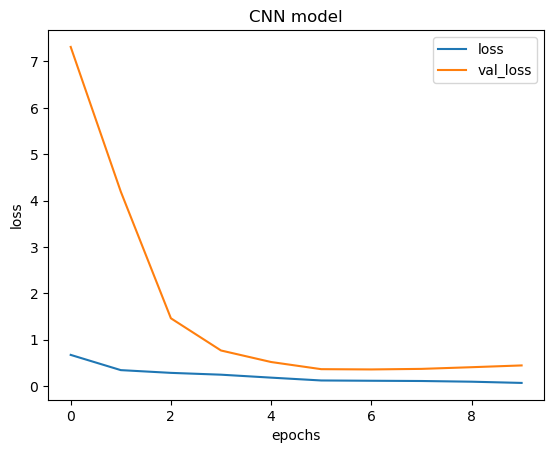

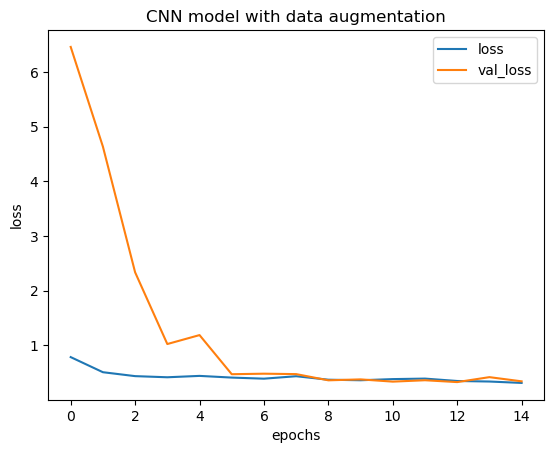

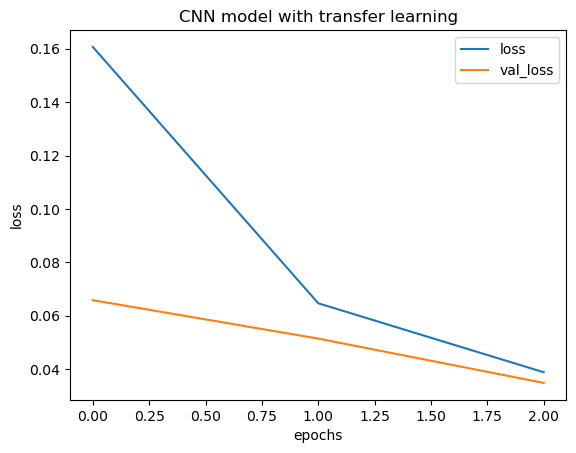

In [17]:
loss_plot(H, 'CNN model')
loss_plot(H_data_augmentation, 'CNN model with data augmentation')
loss_plot(H_VGG16_model, 'CNN model with transfer learning')

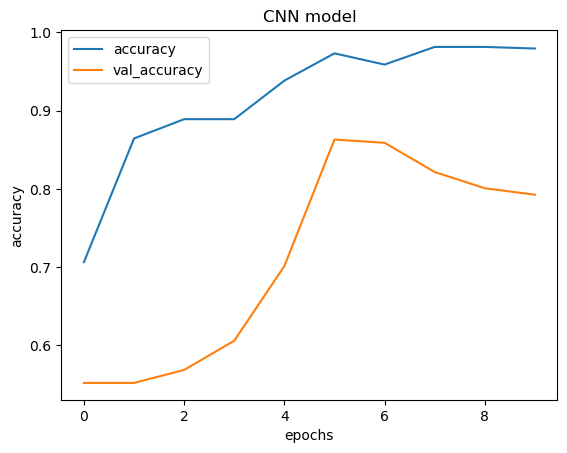

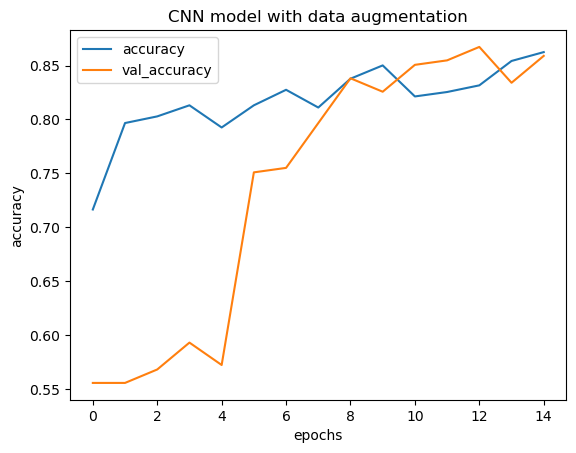

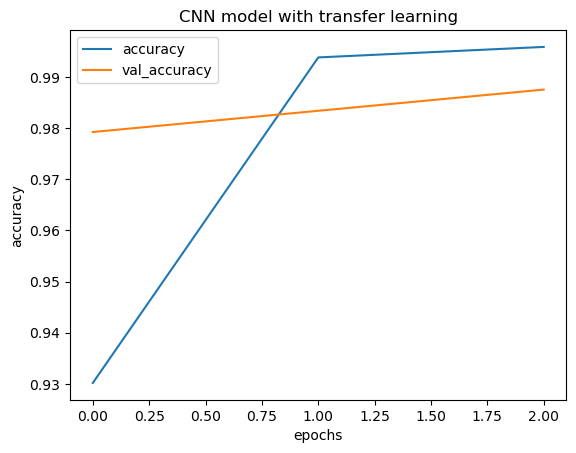

In [18]:
accuracy_plot(H, 'CNN model')
accuracy_plot(H_data_augmentation, 'CNN model with data augmentation')
accuracy_plot(H_VGG16_model, 'CNN model with transfer learning')

## 6) Model performance

Metrics plots

In [19]:
loss, acc = model.evaluate(X_test, y_test)
loss_DA, acc_DA = model_DA.evaluate(X_test, y_test)
VGG16_loss, VGG16_acc = VGG16_model.evaluate(X_test, y_test, batch_size=8)

print('The loss of the CNN is {} and the accuracy is {}.' .format(np.round(loss, 4), np.round(acc, 4)))
print('The loss of the CNN with data augmentation is {} and the accuracy is {}.' .format(np.round(loss_DA, 4), np.round(acc_DA, 4)))
print('The loss of the CNN with transfer learning is {} and the accuracy is {}.' .format(np.round(VGG16_loss, 4), np.round(VGG16_acc, 4)))

45/45 [==============================] - 35s 766ms/step - loss: 0.0808 - accuracy: 0.9694
The loss of the CNN is 0.451 and the accuracy is 0.8028.
The loss of the CNN with data augmentation is 0.3775 and the accuracy is 0.8417.
The loss of the CNN with transfer learning is 0.0808 and the accuracy is 0.9694.


In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion_matrix_plot(model, title, plot=True):
    y_pred = model.predict(X_test)
    y_pred = y_pred.round()
    cm = confusion_matrix(y_test, y_pred)
    
    if plot:
        plt.title(title)
        plot = sns.heatmap(cm, annot=True, fmt='d')
        
    return cm

12/12 [==============================] - 2s 176ms/step


array([[140,  51],
       [ 20, 149]], dtype=int64)

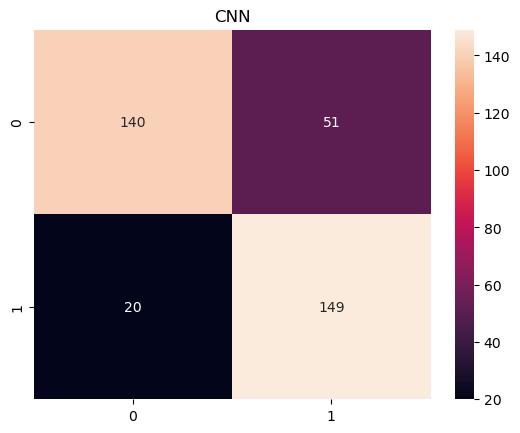

In [21]:
confusion_matrix_plot(model, title='CNN')

12/12 [==============================] - 2s 175ms/step


array([[156,  35],
       [ 22, 147]], dtype=int64)

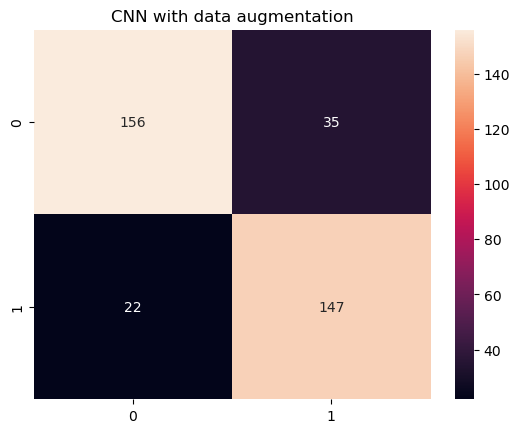

In [22]:
confusion_matrix_plot(model_DA, title='CNN with data augmentation')

12/12 [==============================] - 35s 3s/step


array([[188,   3],
       [  8, 161]], dtype=int64)

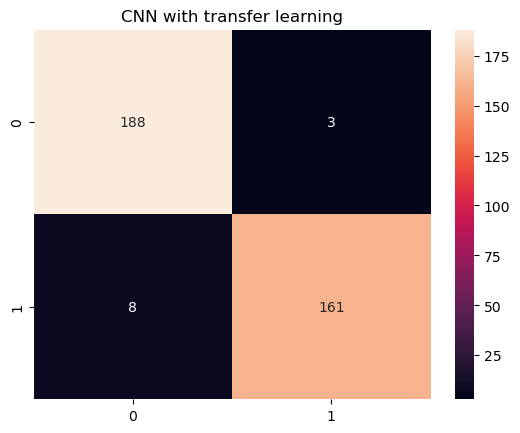

In [23]:
confusion_matrix_plot(VGG16_model, title='CNN with transfer learning')

In [24]:
def precision_recall_f1(model, type_model):

    y_pred = model.predict(X_test)
    y_pred = y_pred.round()

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    type = print(type_model)
    prec = print("Precision:", np.round(precision, 4))
    rec = print("Recall:", np.round(recall, 4))
    F1 = print("F1-score:", np.round(f1, 4))

    return type, prec, rec, F1

In [25]:
precision_recall_f1(model, 'CNN')
precision_recall_f1(model_DA, 'CNN with Data augmentation')
precision_recall_f1(VGG16_model, 'CNN with transfer learning')

12/12 [==============================] - 2s 151ms/step
CNN
Precision: 0.745
Recall: 0.8817
F1-score: 0.8076
12/12 [==============================] - 2s 156ms/step
CNN with Data augmentation
Precision: 0.8077
Recall: 0.8698
F1-score: 0.8376
12/12 [==============================] - 35s 3s/step
CNN with transfer learning
Precision: 0.9817
Recall: 0.9527
F1-score: 0.967


(None, None, None, None)

## 7) Error analysis

Top error interpretation

In [26]:
def misclassified_images(model, gradcam):
    prediction = model.predict(X_test)
    errors = 0
    for i in range(len(prediction)):
        if np.round(prediction[i]) != np.round(y_test[i]):
            errors += 1
            if gradcam:
                explainer = GradCAM()
                image = X_test[i].reshape((1,) + X_test[i].shape)
                grid = explainer.explain((image, None), model, class_index=0)
                plt.imshow(grid)
            else:
                plt.imshow(X_test[i])
            print('Label:', y_test[i])
            print('Prediction:', prediction[i])
            plt.show()
            if errors == 5:
                break

12/12 [==============================] - 2s 174ms/step
Label: 0
Prediction: [0.6352937]


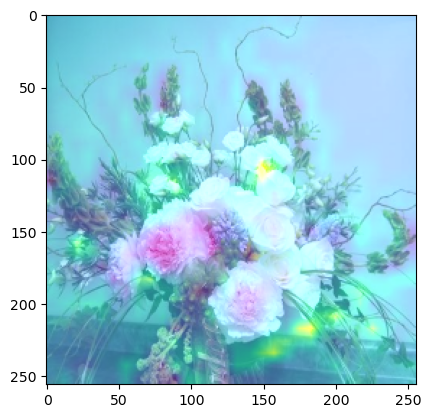

Label: 0
Prediction: [0.59942603]


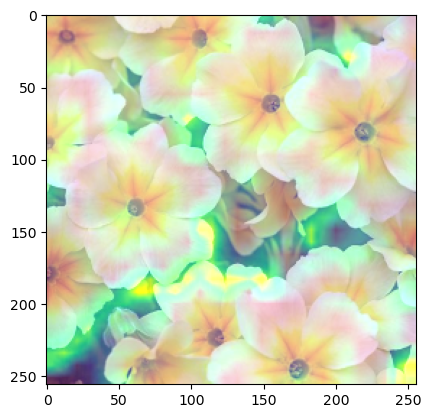

Label: 1
Prediction: [0.39240578]


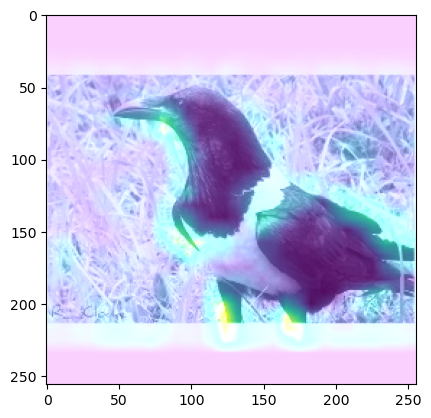

Label: 0
Prediction: [0.8681928]


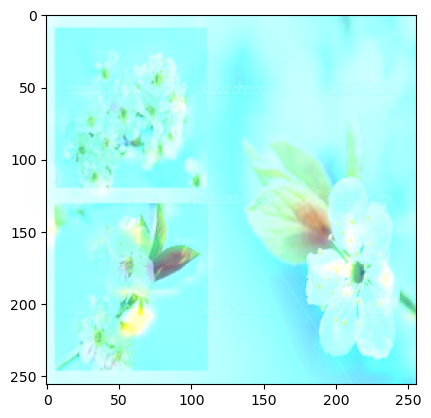

Label: 0
Prediction: [0.598124]


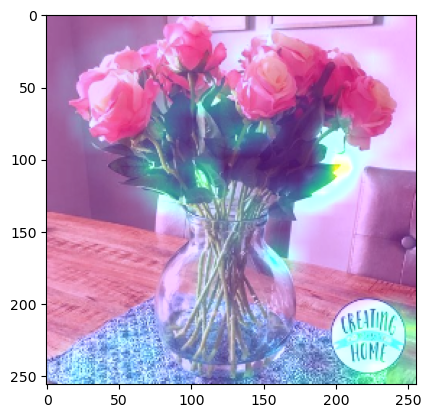

In [27]:
misclassified_images(model, gradcam=True)

12/12 [==============================] - 2s 170ms/step
Label: 1
Prediction: [0.44435668]


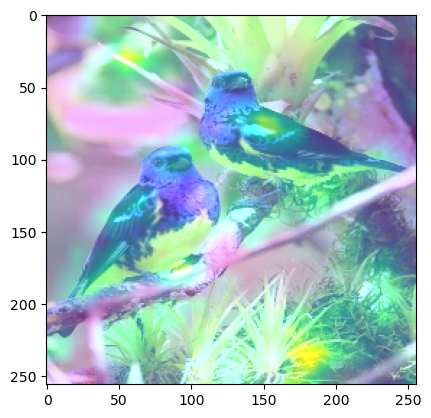

Label: 1
Prediction: [0.33073765]


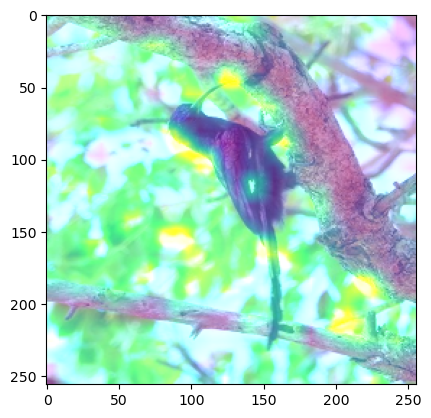

Label: 0
Prediction: [0.56607527]


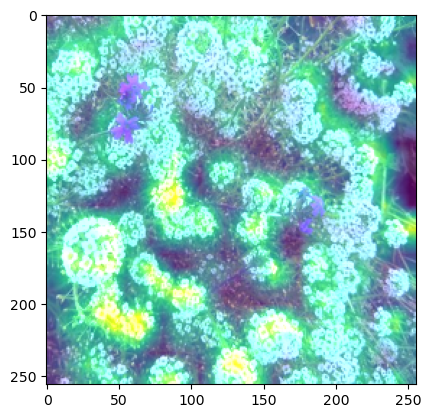

Label: 1
Prediction: [0.37790588]


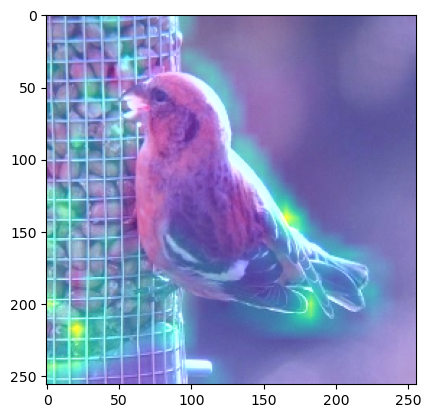

Label: 0
Prediction: [0.5051676]


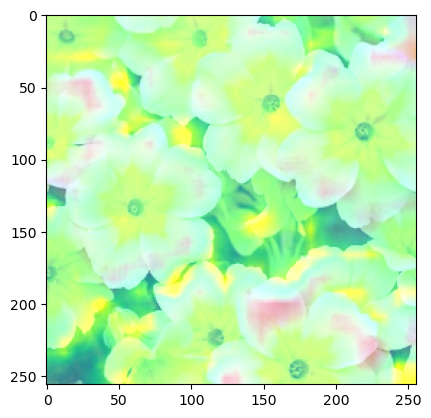

In [28]:
misclassified_images(model_DA, gradcam=True)

12/12 [==============================] - 36s 3s/step
Label: 0
Prediction: [0.9541063]


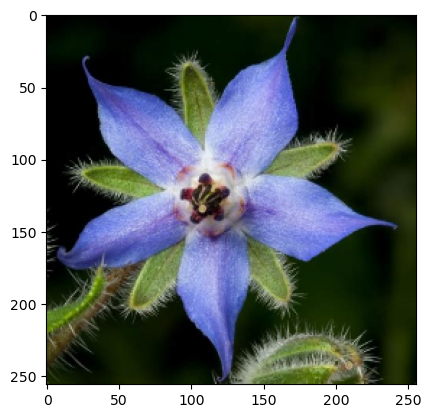

Label: 0
Prediction: [0.9953657]


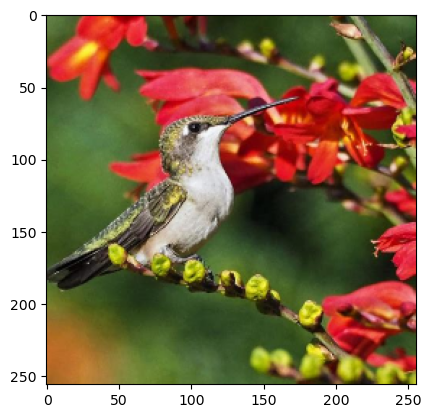

Label: 1
Prediction: [0.12825556]


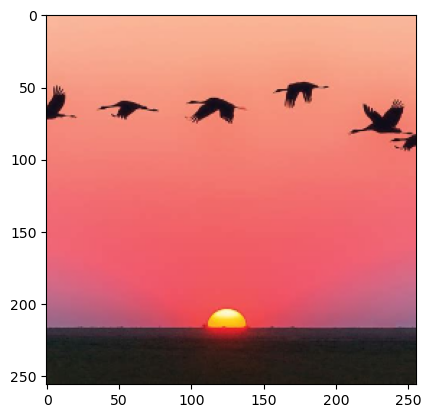

Label: 1
Prediction: [0.37729892]


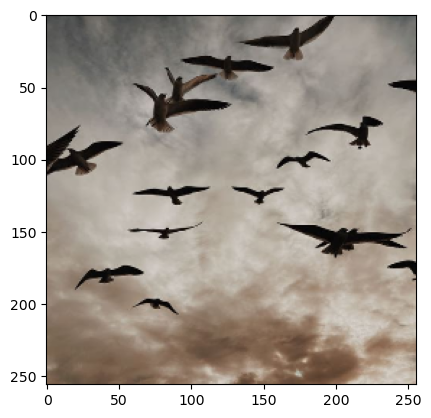

Label: 1
Prediction: [0.37605378]


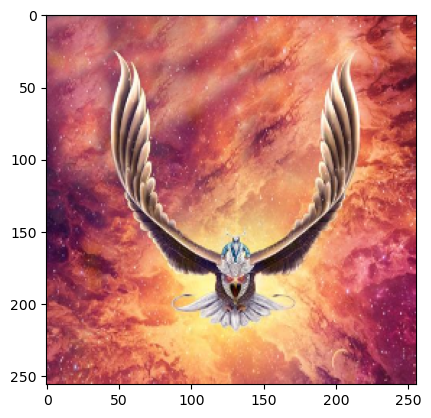

In [29]:
misclassified_images(VGG16_model, gradcam=False)

In [30]:
def classified_images(model, lime):
    prediction = model.predict(X_test)
    correct = 0
    for i in range(len(prediction)):
        if np.round(prediction[i]) == np.round(y_test[i]):
            correct += 1
            if lime:
                explainer = lime_image.LimeImageExplainer(random_state=42)
                explanation = explainer.explain_instance(X_test[i], model.predict, hide_color=0)
                plt.imshow(X_test[i])
                image, mask = explanation.get_image_and_mask(model.predict(X_test[i].reshape((1,256,256,3))).argmax(axis=1)[0], positive_only=False, hide_rest=False)
                plt.imshow(mark_boundaries(image, mask))
            else:
                plt.imshow(X_test[i])
            print('Label:', y_test[i])
            plt.show()
            if correct == 5:
                break

12/12 [==============================] - 2s 169ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step
Label: 1


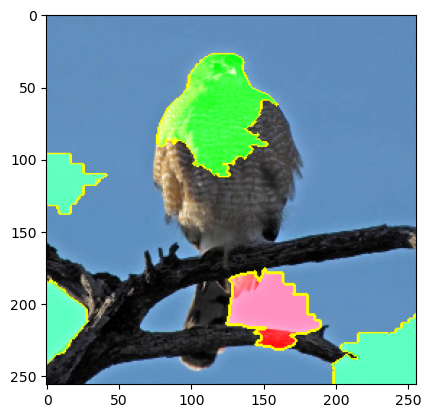

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
Label: 1


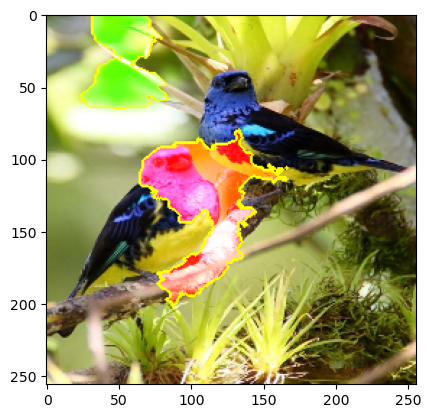

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
Label: 1


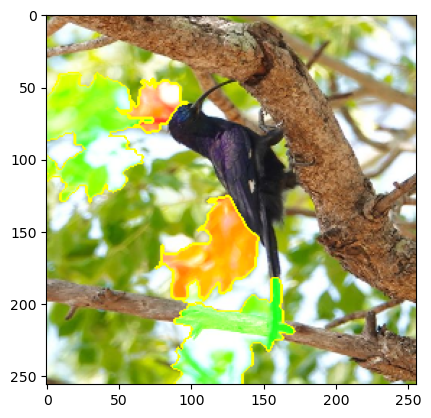

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
Label: 0


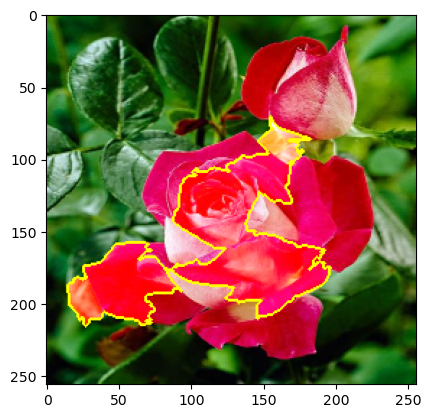

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
Label: 0


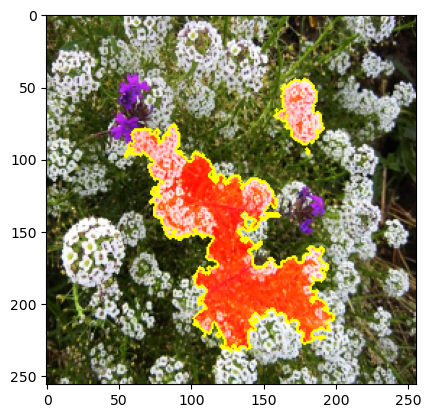

In [31]:
classified_images(model, lime=True)

12/12 [==============================] - 2s 164ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
Label: 1


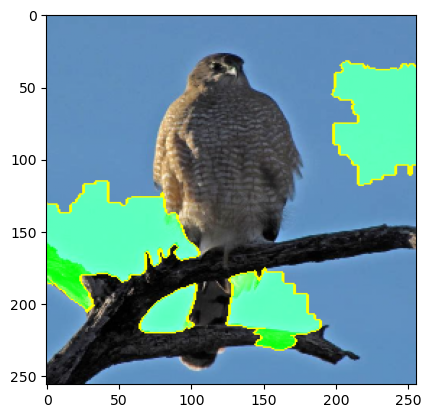

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
Label: 0


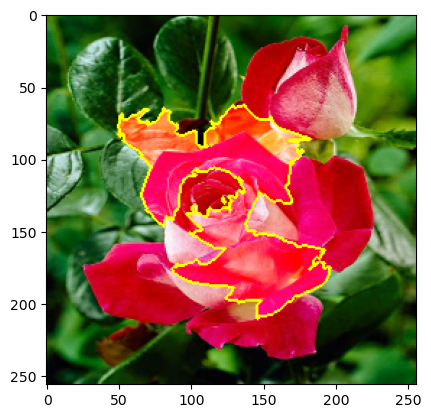

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
Label: 0


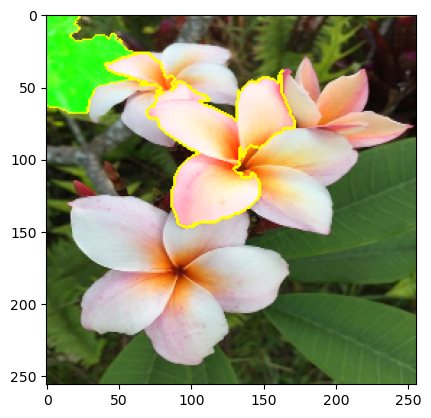

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
Label: 1


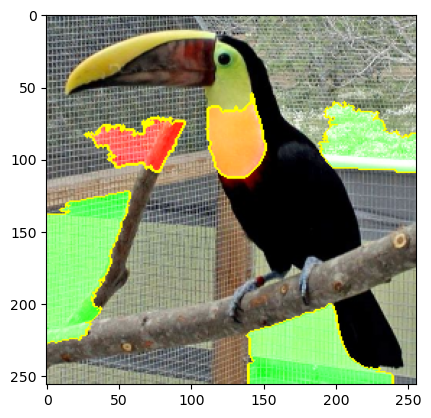

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
Label: 0


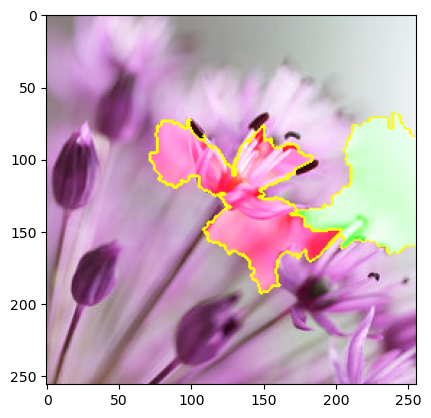

In [32]:
classified_images(model_DA, lime=True)

12/12 [==============================] - 36s 3s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 139ms/step
Label: 1


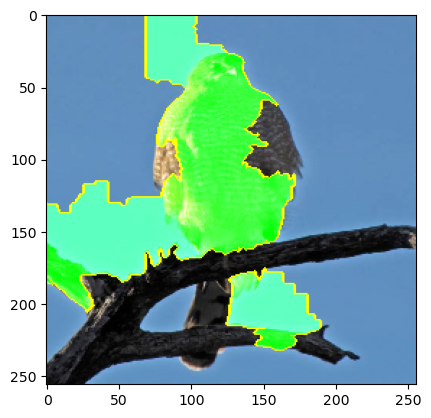

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 152ms/step
Label: 1


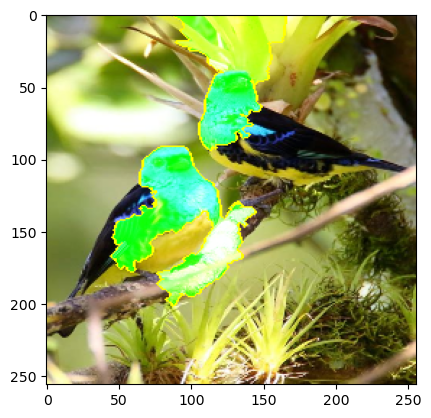

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 135ms/step
Label: 1


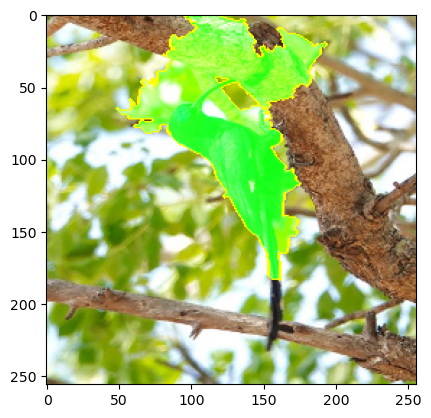

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 149ms/step
Label: 0


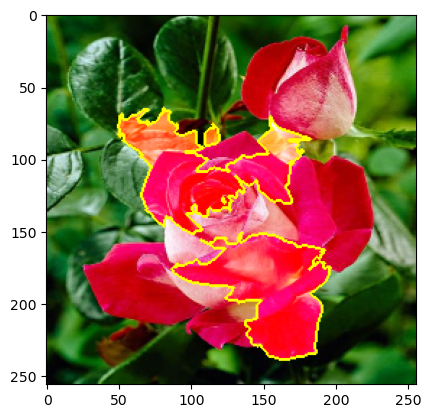

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 131ms/step
Label: 0


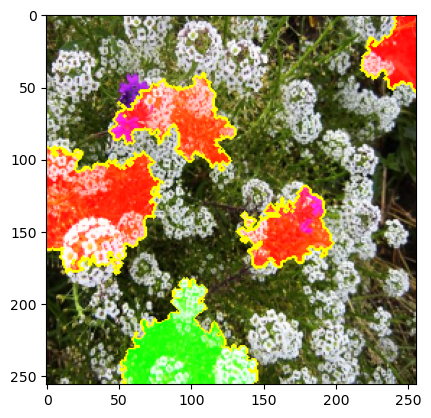

In [33]:
classified_images(VGG16_model, lime=True)